In [64]:
%matplotlib inline

In [77]:
import numpy as np
import pandas as pd
from scipy.stats import gmean
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.filters import threshold_yen

In [66]:
import matplotlib.pyplot as plt

In [67]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from predict import get_prediction_filename

In [68]:
nb_folds = 5
models_names= ['unet', 'unet_ds', ] # ['unet','unet_low','unet_ds','unet_ds2','unet_ds_low','unet_low']
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = True

In [69]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR

In [70]:
threshold = 0.4

In [71]:
models_predictions = {}
for model_name in models_names:
    masks = []
    predictions = []
    for fold_number in range(nb_folds):
        # load data
        dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

        fold_images = [dataset[i][0] for i in range(len(dataset))]
        fold_masks = [dataset[i][1] for i in range(len(dataset))]    

        fold_masks = np.stack(fold_masks)

        # load predictions
        filename = get_prediction_filename(model_name, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
        _, fold_predictions = load_pickle(filename) 

        masks.append(fold_masks)
        predictions.append(fold_predictions)
        
    masks = np.concatenate(masks, axis=0)
    predictions = np.concatenate(predictions, axis=0)
    
    models_predictions[model_name] = predictions

In [72]:
models_predictions.keys()

dict_keys(['unet', 'unet_ds'])

In [73]:
# add mean predictions
models_predictions['gmean'] = gmean([models_predictions[m] for m in models_names], axis=0)
models_predictions['mean'] = np.mean([models_predictions[m] for m in models_names], axis=0)

In [90]:
models_predictions_masks = {}
for model, predictions in models_predictions.items():
    predictions_masks = np.zeros_like(predictions, dtype=np.bool)
    predictions_masks[predictions>threshold] = 1
    
    models_predictions_masks[model] = predictions_masks

In [87]:
# auto thresholds
models_predictions_masks = {}
for model, predictions in models_predictions.items():
    ths = [threshold_yen(p) for p in predictions]
    
    predictions_masks = [p <= th for p, th in zip(ths, predictions)]
    
    models_predictions_masks[model] = np.stack(predictions_masks, axis=0)

In [91]:
models_scores = {}
for model, predictions_masks in models_predictions_masks.items():
    score = topcoder_metric(masks, predictions_masks)
    
    models_scores[model] = score

In [92]:
for model, score in models_scores.items():
    print('{0:<15} {1}'.format(model, score))

unet            854184.3677182517
unet_ds         855778.1279291501
gmean           858841.1095664164
mean            858587.3309670314


## Remove small objects

In [42]:
scores = []
for size in range(10,200,25):
    predictions_mask_wo = remove_small_objects(models_predictions_masks['gmean'].astype(np.bool), size)
    predictions_mask_wh = remove_small_holes(models_predictions_masks['gmean'].astype(np.bool), size)
    predictions_mask_who = remove_small_holes(remove_small_objects(models_predictions_masks['gmean'].astype(np.bool), size), size)
    
    score_wo = topcoder_metric(masks, predictions_mask_wo.astype(np.float))
    score_wh = topcoder_metric(masks, predictions_mask_wh.astype(np.float))
    score_who = topcoder_metric(masks, predictions_mask_who.astype(np.float))
        
    scores.append({'size': size,'objects': score_wo, 'holes':score_wh, 'objects_holes': score_who})

In [43]:
scores = pd.DataFrame(scores)

In [44]:
scores

,holes,objects,objects_holes,size
0,857210.987965,857211.575037,857215.616437,10
1,857217.152756,857239.748796,857249.955354,35
2,857217.404646,857231.440556,857241.899303,60
3,857218.642741,857265.289799,857276.986083,85
4,857215.561028,857247.248379,857255.868922,110
5,857215.561028,857278.416488,857287.045583,135
6,857215.561028,857201.113339,857209.742203,160
7,857215.561028,857206.882924,857215.512027,185


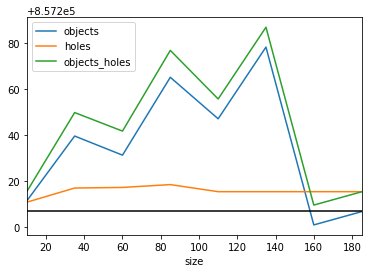

In [45]:
ax = scores.plot(x='size', y=['objects','holes','objects_holes',])
ax.axhline(y=models_scores['gmean'], c='black')